# TO DO
* IMAGE SIZE - 512 * 64 (why?)
* try spectogram: chromagram (raw waveforms (not a spect.))
* try transformer

* TRY NORMALISE THE CHROMAGRAM
* SR - TRY TO TAKE SR VALUES FROM THE DATASET


* SIMPLE BASENET
* IMPROVE VAE NET
* LOOK INTO NSCNET ALTERNATIVES
* LOOK INTO METRIC LEARNING AND SIMILARITY RETRIEVAL

# TO ASK THE TUTOR

WHAT THE TUTOR SAID

noise: analyzing the noise in an empirical way--> listening to the songs
alternative: we could fine tune the threshold

normalize out of all the songs

make sure the padding doesn't interfere with other images

# look at the data
analyze duration, understand how big to make the chromagram images

    the images are the same size, but the same amount of of time is different in different signals
    
    let's choose a threshold where to truncate and pad
    
analyze frequencies, are there frequencies we should cut

    is there noise we should cut (we don't think so)
    
do the chromagram

# Utils

* https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/

* https://ridakhan5.medium.com/audio-clustering-with-deep-learning-a7991d605fa5

* https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

* https://www.researchgate.net/publication/333427516_Feature_Learning_for_Bird_Call_Clustering

* https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225

* https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

* https://musicinformationretrieval.com/kmeans.html

* Feature Normalization: https://www.hackaudio.com/digital-signal-processing/amplitude/peak-normalization/#:~:text=Normalizing%20the%20amplitude%20of%20a,magnitude%20equals%20a%20specified%20level.&text=This%20opens%20in%20a%20new%20window.&text=Peak%20amplitude%20is%20a%20measurement%20based%20the%20instantaneous%20level%20of%20a%20signal.

* https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_FeatureNormalization.html

* https://stackoverflow.com/questions/48257311/signal-processing-can-someone-explain-for-me-the-different-type-of-spectrogram

* https://www.geeksforgeeks.org/plotting-a-spectrogram-using-python-and-matplotlib/

* https://it.mathworks.com/matlabcentral/answers/319352-how-do-i-perform-clustering-of-audio-signal

wav files seconds
* https://stackoverflow.com/questions/13039846/what-do-the-bytes-in-a-wav-file-represent

In [1]:
#!pip install librosa
from pathlib import Path
import os
import pandas as pd
import librosa
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt
from tqdm import tqdm 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import keras 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img
import pickle 

2023-01-25 19:25:13.023929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#constants
SR = 22050

In [3]:
DIR = './dataset/songs_extracted'

In [4]:
#function that loads the songs from the songs_extracted dataset
def load_songs_extracted(directory):
    data = []
    for bird_names in os.listdir(directory)[:1]: #comment/delete [:1] to run on the whole dataset
        path_bird_names = os.path.join(directory, bird_names)
        if os.path.isdir(path_bird_names):
            for channel in os.listdir(path_bird_names):
                if channel == "CH2":
                    path_channel  = os.path.join(path_bird_names, channel)
                    if os.path.isdir(path_channel):
                        for song in  os.listdir(path_channel):
                            song_num = int(re.search('\d+', song).group())
                            path_song = os.path.join(path_channel, song)
                            signal, sr = librosa.load(path_song)
                            data.append([bird_names, song_num, sr, signal]) #channel is CH2 by default

    # return dataframe creation
    return pd.DataFrame(data, columns=['bird', 'song', 'sr', 'signal'])

In [5]:
df = load_songs_extracted(Path(DIR))
df.head()

,bird,song,sr,signal
0,stanlio_con,114,22050,"[-7.806963e-05, -8.764093e-05, -0.00010633859,..."
1,stanlio_con,100,22050,"[0.00062858325, 0.0004293403, -0.00032932722, ..."
2,stanlio_con,128,22050,"[-1.606754e-05, -8.9533954e-05, -5.259977e-05,..."
3,stanlio_con,20,22050,"[-8.676458e-06, -1.4932111e-05, -2.3282313e-05..."
4,stanlio_con,34,22050,"[-0.00034999382, -0.00043660673, -6.6233515e-0..."


In [6]:
df.shape

(132, 4)

In [7]:
print(df['signal'][0].shape)
print(df['signal'][0])

(82969,)
[-7.8069628e-05 -8.7640932e-05 -1.0633859e-04 ... -1.0349114e-03
  2.2598934e-04  2.5019988e-03]


In [8]:
import IPython.display as ipd
ipd.Audio(df.iloc[0]['signal'], rate=SR)

# Preprocessing

truncation: understand if having signals of different length is a problem

normalization: understand how and if to normalize (-1,1)

### Padding

In [9]:
def pad_signals(df, policy = "truncation", seconds = 11):

    df['signal_length'] = df['signal'].apply(lambda x: len(x))
    mean = np.mean(df['signal_length'])
    mean = int(mean)
    print('mean:', mean)
    print('standard deviation:', np.std(df['signal_length']))
    print(df[df['signal_length'] < 100000]['signal_length'].count(), 'signals are not truncated out of', df['signal_length'].count())

    if policy == 'padding':
        maxim = np.max(df['signal_length'])
        print(maxim)
        df['padded_signal'] = df['signal'].apply(lambda x: np.pad(x, (0, maxim-len(x))) )

    elif policy == 'truncation':
        #TODO truncation
        trunc_thresh = seconds*22050  #maxim
        #padding
        df['padded_signal'] = df['signal'].apply(lambda x: np.pad(x, (0, trunc_thresh-len(x))) if len(x)<trunc_thresh else x) 
        #truncation
        df['padded_signal'] = df['padded_signal'].apply(lambda x: x[0:trunc_thresh] if len(x)>trunc_thresh else x) 

    print(len(df['padded_signal'][1]))
    return df    

In [10]:
df = pad_signals(df, policy = "truncation", seconds = 11)

mean: 80394
standard deviation: 32898.33784032681
107 signals are not truncated out of 132
242550


### Amplitude Normalization
if we want to normalize the signals using their own max value for each, we don't need to do it
cause the chromagram ALREADY DOES IT

we can try to normalize all the signals together using the highest value in all the dataset
so the relationships between signal amplitudes is kept

here we are doing the first method

In [11]:
max_df = df['padded_signal'].apply(lambda x : np.max(np.abs(x))).max()
print(max_df)

0.6052681


In [12]:
df['normalized_signal'] = df['padded_signal'].apply(lambda x: x/max_df)

#df['normalized_signal'] = df['padded_signal'].apply(lambda x: x/np.max(np.abs(x)))
print(np.max(np.abs(df['normalized_signal'][0])))

0.5987729


### Filtering
We read on nscnet that they removed the noise.
We followed their idea, but are not sure if ch1 (the one they used) is more noisy than ch2 and so we don't need it.

We need to find a way to properly asses the level of noise in the data.

In [13]:
sr = SR     
order = 5
lf = 1500
filtered = []
def high_pass(sig):
    nyq = sr/2
    sos = butter(order, [lf/nyq], analog=False, btype='highpass', output='sos')
    return sosfiltfilt(sos,sig)

df['filtered_signal'] = df['padded_signal'].apply(lambda x: high_pass(x))    

### Chromagrams

In [14]:
chromagrams = []
for signal in df['filtered_signal']:
    chrom = librosa.feature.chroma_stft(y=signal, sr=SR)
    chromagrams.append(chrom)
    
#chromagrams = df['normalized_signal'].apply(lambda x: librosa.feature.chroma_stft(y=x, sr=SR))

In [15]:
#chromagrams

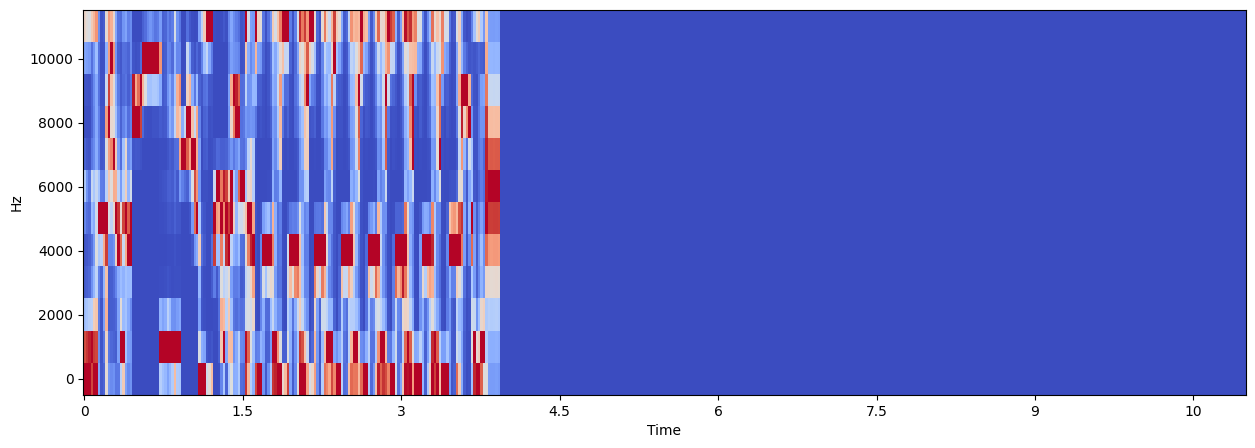

In [16]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagrams[0], x_axis='time', y_axis='hz', hop_length=512, cmap='coolwarm')

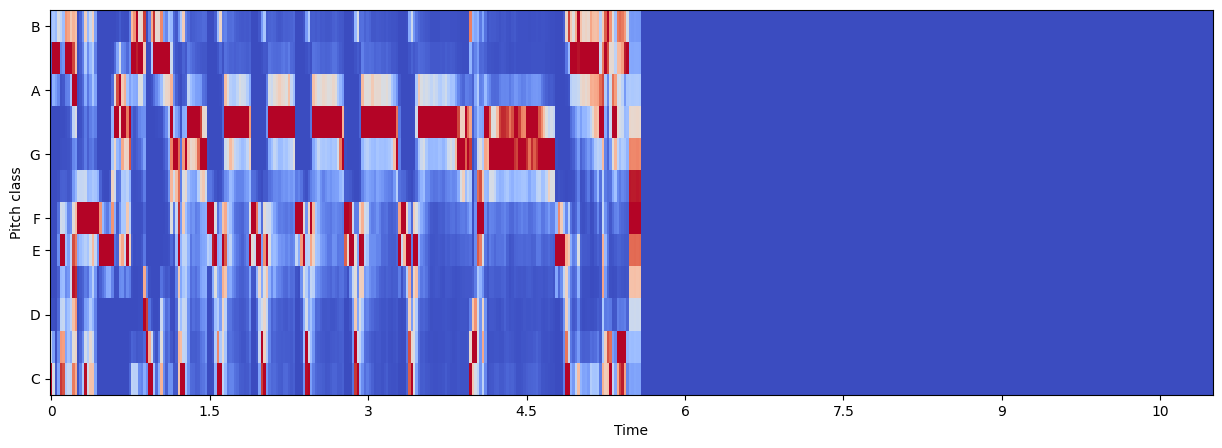

In [17]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagrams[120], x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

## PCA
n_components: either automatic, or with 12 (because we have 12 pitches)

In [ ]:
chromagrams_array = np.array(chromagrams)
print(chromagrams[0].shape)
print(chromagrams_array.shape)

#x = pca.fit_transform(chromagrams_array)

#pca_chromagrams = chromagrams_array.apply(lambda x: pca.fit_transform(x))

pca_chromagrams = []
for x in chromagrams:
    res = PCA().fit_transform(x)
    res = res.reshape(res.shape[0]*res.shape[1])
    pca_chromagrams.append(res)

In [ ]:
pca_chromagrams

In [ ]:
#print(chromagrams[11].shape)
a_pca_chromagrams = np.asarray(pca_chromagrams)
a_pca_chromagrams.shape

In [ ]:
#librosa.display.specshow(pca_chromagrams[3], x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

In [ ]:
'''squared_distances = []
for k in range(1,15):
    km = KMeans(n_clusters=k)
    km = km.fit_transform(pca_chromagrams)
    squared_distances.append(km.inertia_)'''

#clusters = KMeans(n_clusters=8, max_iter=10, random_state=0).fit_transform(pca_chromagrams)
#print(clusters)

cluster_number = range(2,120) 

distortions = []
silhouette_scores = []
for n in cluster_number:
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(pca_chromagrams)
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(pca_chromagrams,y))

In [ ]:
# Create some mock data
t = cluster_number
data1 = distortions
data2 = silhouette_scores

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

there's no elbow O.O

In [ ]:
#librosa.display.specshow(clusters, x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')

FOR KMEANS CLUSTERING:
compute the predictions:   cluster_predictions = kmeans.fit_predict(x)
find an evaluation method he uses silhouette score

### plot

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_clusters(X, y, dim, points,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10) # by default the last of the map (to be improved)
                 ):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    plt.scatter(points[:,dim[0]], 
                points[:,dim[1]], 
                s=50, 
                marker='*', 
                c=[points_color], 
                label=points_name)
    plt.legend()
    plt.grid()
    plt.show() 

In [ ]:
X = np.array(pca_chromagrams)
print(X.shape)

In [ ]:
# to fill
good_k = 15

estimator = KMeans(n_clusters = good_k, init='k-means++', n_init=10, max_iter=300,)
y = estimator.fit_predict(X)

#estimator.cluster_centers_

In [ ]:
#import seaborn as sns
#sns.pairplot(pd.DataFrame(X[:,0:10]))

In [ ]:
plt.scatter(X[:,0], X[:,1], c='white', edgecolors='black', marker='o', s=50)

In [ ]:
plot_clusters(X, y, dim= (0,1), points= estimator.cluster_centers_)
              #, ['cluster0', 'cluster1', 'cluster2'], ['centroids'],
             #['blue', 'red', 'pink'], ['cyan'])

In [26]:
## Jens function for getting a chromagram
plt.figure(figsize=(30, 10))
print("Saving the chromagrams as png images. It may take a while...")
for i in tqdm(range(len(chromagrams))):
    librosa.display.specshow(chromagrams[i], x_axis='time', y_axis='chroma', hop_length=512, cmap='coolwarm')
    if not os.path.exists("chromagrams/" + str(i) + "out.png"):
        plt.savefig("chromagrams/" + str(i) + "out.png", bbox_inches='tight', facecolor='white')
    plt.clf()

Saving the chromagrams. It may take a while...


100%|█████████████████████████████████████████████████████████| 132/132 [01:05<00:00,  2.01it/s]


<Figure size 3000x1000 with 0 Axes>

## Trying ResNet50

In [27]:
import os
import keras
from keras import applications

PATH = os.getcwd() + '/chromagrams'
#os.path.isdir(PATH)

In [35]:
chromagrams_imgs = []
with os.scandir(PATH) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            chromagrams_imgs.append(file.name)

In [36]:
len(chromagrams_imgs)

132

In [93]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Flatten, Dense, Dropout

#Resnet model
import keras 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img

In [99]:
#resnet = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(132,144,3)) #default (224,224,3) our chromgram is 12x474 but the min is 32x32
resnet = ResNet50(include_top=False, pooling='avg', weights='imagenet') #not specifying input shape the output shape is different there is no the 5,5
model = Sequential()
#model.layers[0].trainable = False #only first layer non trainable
for layer in model.layers: #each layer is non trainable (we don't have to train the model)
    layer.trainable=False

model.add(resnet)
#additional layers added
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(5, activation='softmax'))

#TRY https://stackoverflow.com/questions/64984888/add-layers-into-keras-pretrained-model
#TRY https://datagen.tech/guides/computer-vision/resnet-50/


In [100]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [101]:
import cv2
def extract_features(path, model):
    resnet_feature_list = []
    images = [f for f in os.listdir(PATH)]
    for image in images:
        if image != ".DS_Store": #mac stupid file issues :(
            file = PATH+"/"+image
            print("prediction image:", image)
            im = cv2.imread(file)
            im = cv2.resize(im,(144,132)) #comment it or not?
            img = preprocess_input(np.expand_dims(im.copy(), axis=0))
            resnet_feature = model.predict(img) #predictions are all zeros
            resnet_feature_np = np.array(resnet_feature)
            resnet_feature_list.append(resnet_feature_np.flatten())
    array = np.array(resnet_feature_list)
    return array

In [102]:
features = extract_features(PATH, model)

prediction image: 21out.png
1/1 [==============================] - 1s 1s/step
prediction image: 42out.png
1/1 [==============================] - 0s 81ms/step
prediction image: 103out.png
1/1 [==============================] - 0s 75ms/step
prediction image: 33out.png
1/1 [==============================] - 0s 77ms/step
prediction image: 111out.png
1/1 [==============================] - 0s 77ms/step
prediction image: 50out.png
1/1 [==============================] - 0s 77ms/step
prediction image: 78out.png
1/1 [==============================] - 0s 76ms/step
prediction image: 127out.png
1/1 [==============================] - 0s 75ms/step
prediction image: 66out.png
1/1 [==============================] - 0s 77ms/step
prediction image: 17out.png
1/1 [==============================] - 0s 80ms/step
prediction image: 74out.png
1/1 [==============================] - 0s 83ms/step
prediction image: 2out.png
1/1 [==============================] - 0s 85ms/step
prediction image: 87out.png
1/1 [=======

1/1 [==============================] - 0s 79ms/step
prediction image: 108out.png
1/1 [==============================] - 0s 82ms/step
prediction image: 34out.png
1/1 [==============================] - 0s 77ms/step
prediction image: 57out.png
1/1 [==============================] - 0s 80ms/step
prediction image: 116out.png
1/1 [==============================] - 0s 78ms/step
prediction image: 61out.png
1/1 [==============================] - 0s 83ms/step
prediction image: 120out.png
1/1 [==============================] - 0s 81ms/step
prediction image: 10out.png
1/1 [==============================] - 0s 81ms/step
prediction image: 73out.png
1/1 [==============================] - 0s 75ms/step
prediction image: 5out.png
1/1 [==============================] - 0s 85ms/step
prediction image: 9out.png
1/1 [==============================] - 0s 79ms/step
prediction image: 80out.png
1/1 [==============================] - 0s 78ms/step
prediction image: 92out.png
1/1 [==============================] - 

In [103]:
print(features)
print(features.shape)

[[0.48502854 0.04219931 0.01906312 ... 0.36701447 0.34072274 0.09386219]
 [0.34369946 0.         0.2537504  ... 1.1567461  0.0438824  0.27507928]
 [0.24400395 0.2913825  0.09215459 ... 0.2207069  0.         0.801826  ]
 ...
 [0.04475875 0.08719526 0.         ... 0.5473605  0.11998276 0.18201263]
 [0.01348071 0.06127813 0.09539485 ... 0.44734624 0.20155771 0.196496  ]
 [0.28423297 0.08343493 0.02652472 ... 0.01657721 0.00932688 0.5290929 ]]
(132, 2048)


In [64]:
#!pip install opencv-python

In [ ]:
"""def extract_features_old(file, model):
    # load the image as a 224x224 array
    #img = load_img(PATH + "/" + file, target_size=(132,144))
    # convert from 'PIL.Image.Image' to numpy array
    path = PATH + "/" + file
    #print(file)
    load_img = cv2.imread(path)
    #resized_img = cv2.resize(load_img, (144, 132)) 
    #print(resized_img.shape)
    #im = cv2.resize(im,(256,256))
    img = preprocess_input(np.expand_dims(load_img.copy(), axis=0))
    
    #img = np.array(img) 
    #print("iMG SHAPE")
    #print(img.shape)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    #reshaped_img = img.reshape(1,132,144,3)
    #print(reshaped_img.shape)
    # prepare image for model
    #img = preprocess_input(img_prep)
    # get the feature vector
    features = model.predict(img) #pass as param imgx
    print("FEATURES SHAPE")
    print(features.shape)
    return features"""

In [ ]:
"""data = {}
#p = r"CHANGE TO A LOCATION TO SAVE FEATURE VECTORS"

print("Extracting the features. It may take a while...")
for chromagram in chromagrams_imgs:
    # try to extract the features and update the dictionary
    feat = extract_features(PATH,model)
    data[chromagram] = feat"""

In [ ]:
#filenames = np.array(list(data.keys()))
# get a list of just the features
#features_resnet = np.array(list(data.values()))
#print("feat shape")
#print(features_resnet.shape) #(264, 1, 5, 5, 2048) #wtf is 1,5,5 ??
#feat_reshaped = feat.reshape(-1,2048) #samples are 264, use the 2048 vectors of the predictions
#print(feat_reshaped.shape)

In [104]:
res = PCA(n_components=100, random_state=22).fit_transform(features) #feat
res.shape
#res = res.reshape(res.shape[0]*res.shape[1])

(132, 100)

In [105]:
cluster_number = range(2,10) 

distortions = []
silhouette_scores = []
for n in cluster_number:
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(res)
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(res,y))

In [106]:
#np.unique(estimator.labels_)

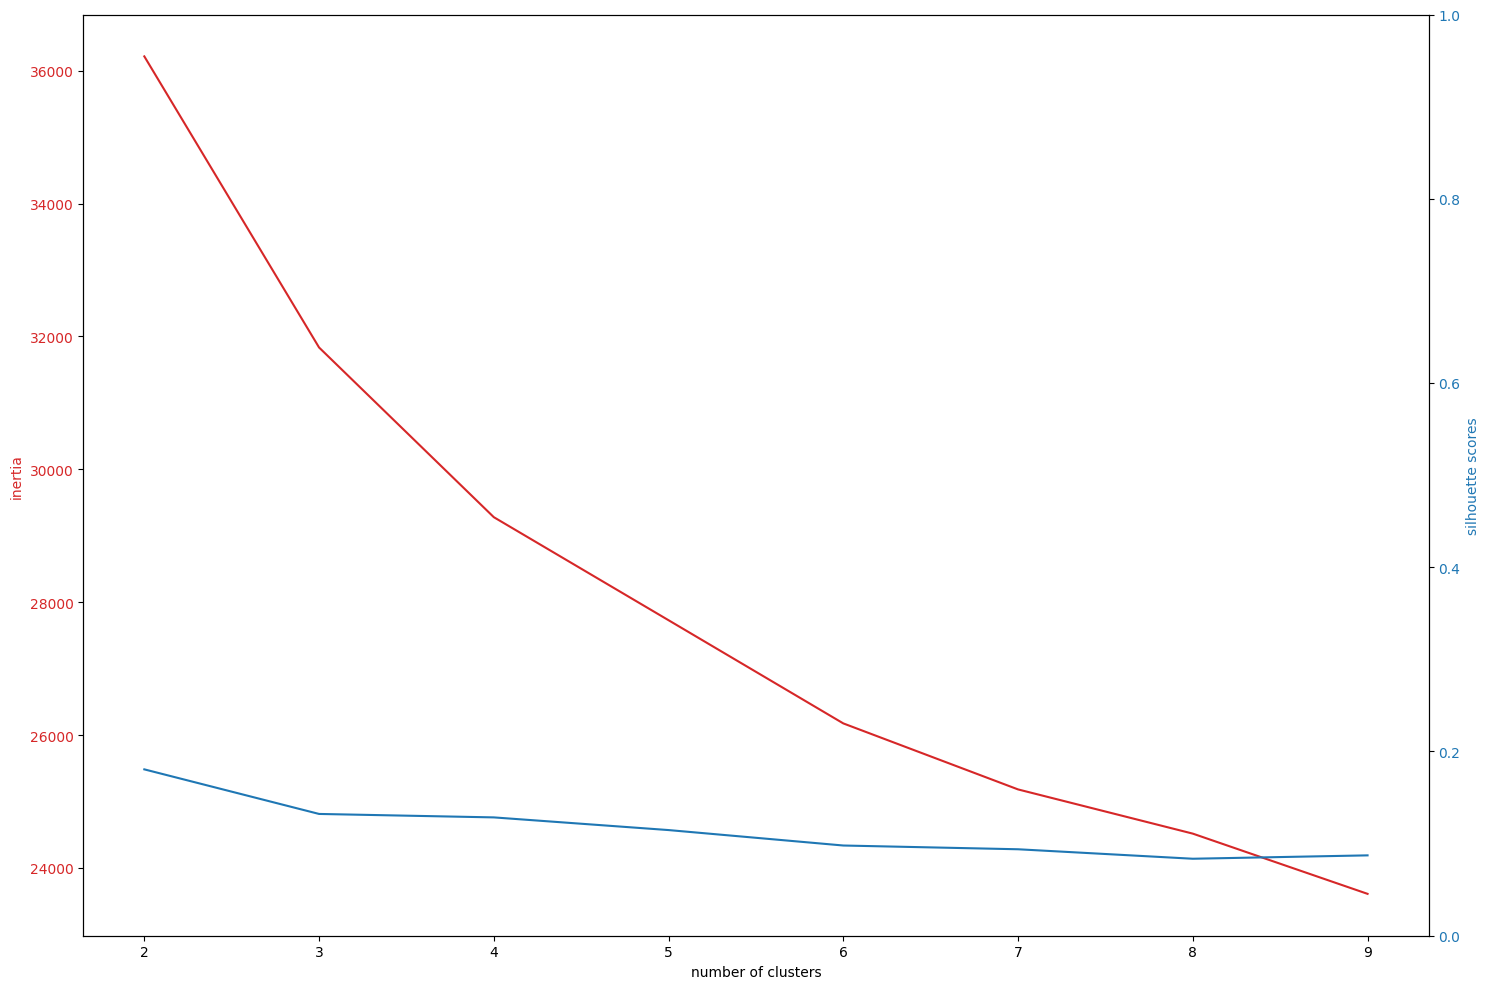

In [107]:
# Create some mock data
t = cluster_number
data1 = distortions
data2 = silhouette_scores

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [108]:
estimator = KMeans(n_clusters = 4, init='k-means++', n_init=10, max_iter=300)
y = estimator.fit_predict(res)

(132, 100)


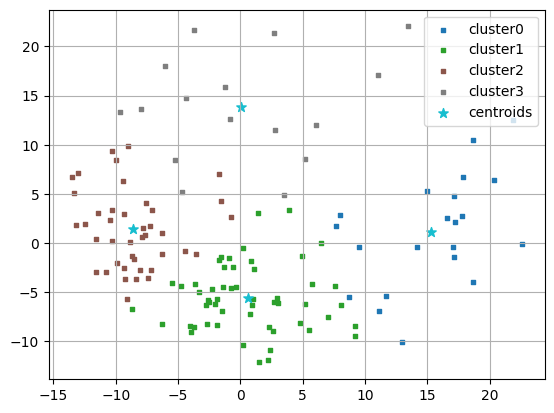

In [109]:
X = np.array(res)
print(X.shape)

plot_clusters(X, y, dim=(0,1), points= estimator.cluster_centers_)

# *************************stop***************************

## Trying VGG16 

* https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

I try VGG16 as feature extractor and then applying k-means and PCA (to integrate to the previous approach)